<a href="https://colab.research.google.com/github/rsvega25/pronostico_hidrologico_PITA_LSTM/blob/main/APIH_PITA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conformación del dataset

In [ ]:
# Monto drive al colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Realizo un mapa con archivos cargados en mi drive
!pip install cartopy
!pip install geopandas
!pip install rasterio
!pip install cftime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.0 MB/s eta 0:00:00


In [ ]:
# Importo librerias
import rasterio
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import xarray as xr
import cartopy.crs as crs
import cftime
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit  # optional for time series
from IPython.display import display, HTML

In [ ]:
# Cargo csv de direcciones de series de tiempo de la red de monitoreo
path = '/content/drive/MyDrive/RED_PARAMH2O/Inventario_PITA.csv'
base = pd.read_csv(path)
base.head()

,Codigo,Nombre,X_UTM17S,Y_UTM17S,Z_msnm,Cod_variables,simb,Direccion
0,ATP01HI01,Tungurahua,790752.76,9932329.12,3840,tem_agu,Th2o (degC),/content/drive/MyDrive/RED_PARAMH2O/DT_SUBHORA...
1,ATP01HI01,Tungurahua,790752.76,9932329.12,3840,niv_agu,h (cm),/content/drive/MyDrive/RED_PARAMH2O/DT_SUBHORA...
2,ATP01HI01,Tungurahua,790752.76,9932329.12,3840,cau,Q (LPS),/content/drive/MyDrive/RED_PARAMH2O/DT_SUBHORA...
3,ATP01HI02,Vertedero en Humedal Tungurahua,793016.81,9932957.58,3889,tem_agu,Th2o (degC),/content/drive/MyDrive/RED_PARAMH2O/DT_SUBHORA...
4,ATP01HI02,Vertedero en Humedal Tungurahua,793016.81,9932957.58,3889,niv_agu,h (cm),/content/drive/MyDrive/RED_PARAMH2O/DT_SUBHORA...


In [ ]:
# Función para Crear el Diccionario segun 'cod_var'
def crear_diccionario_desde_csv(ruta_csv):
    """
    Crea un diccionario con estructura {cod_var: {cod_est: {'direccion': str, 'ts': DataFrame}}}.
    """
    df = pd.read_csv(ruta_csv)
    df['Codigo'] = df['Codigo'].str.strip()  # Limpiar espacios

    estaciones = {}
    for _, row in df.iterrows():
        cod_var = row['Cod_variables']
        cod_est = row['Codigo']
        direccion = row['Direccion']

        if cod_var not in estaciones:
            estaciones[cod_var] = {}
        estaciones[cod_var][cod_est] = {
            'direccion': direccion,
            'ts': None  # Placeholder para la serie temporal
        }
    return estaciones

In [ ]:
# Función para Cargar por variable las Series Temporales en el Diccionario
def cargar_series_temporales_var(estaciones, variable):
    """
    Carga las series temporales desde las rutas y las almacena en el diccionario para la variable especificada.
    """

    # Verificar si la variable existe en el diccionario
    if variable not in estaciones:
        print(f"⚠️ Error: La variable '{variable}' no existe en el diccionario.")
        return

    # Iterar solo sobre las estaciones de la variable especificada
    for cod_est in estaciones[variable]:
        try:
            # Obtener ruta del archivo
            ruta = estaciones[variable][cod_est]['direccion']

            # Leer y procesar datos
            ts = pd.read_csv(ruta)
            ts['fecha'] = pd.to_datetime(ts['fecha'])
            ts = ts.set_index('fecha')

            # Almacenar en el diccionario
            estaciones[variable][cod_est]['ts'] = ts
            print(f"✅ Serie de {cod_est} ({variable}) cargada correctamente.")

        except Exception as e:
            print(f"🚨 Error en {cod_est} ({variable}): {str(e)}")
            estaciones[variable][cod_est]['ts'] = None

In [ ]:
# Crear diccionario para variable todas las variables
estaciones = crear_diccionario_desde_csv(path)

In [ ]:
# Mostrar resultado
print("Diccionario generado:")
for cod_var, datos in estaciones.items():
    print(f"\nVariable: {cod_var}")
    for cod_estacion, direccion in datos.items():
        print(f"  - Estación {cod_estacion}: {direccion}")

Diccionario generado:

Variable: tem_agu
  - Estación ATP01HI01: {'direccion': '/content/drive/MyDrive/RED_PARAMH2O/DT_SUBHORARIO/HIDROMETRICA/ATP01HI01/ATP01HI01-Tungurahua_Temperatura_de_agua-Subhorario_validado.csv', 'ts': None}
  - Estación ATP01HI02: {'direccion': '/content/drive/MyDrive/RED_PARAMH2O/DT_SUBHORARIO/HIDROMETRICA/ATP01HI02/ATP01HI02-VERTEDERO_EN_HUMEDAL_TUNGURAHUA_Temperatura_de_agua-Subhorario_validado.csv', 'ts': None}
  - Estación ATP02HI01: {'direccion': '/content/drive/MyDrive/RED_PARAMH2O/DT_SUBHORARIO/HIDROMETRICA/ATP02HI01/ATP02HI01-Chamilco_Temperatura_de_agua-Subhorario_validado.csv', 'ts': None}
  - Estación H12: {'direccion': '/content/drive/MyDrive/RED_PARAMH2O/DT_SUBHORARIO/HIDROMETRICA/H12/H12-Pita_Bocatoma_Temperatura_de_agua-Subhorario_validado.csv', 'ts': None}
  - Estación H5009: {'direccion': '/content/drive/MyDrive/RED_PARAMH2O/DT_SUBHORARIO/HIDROMETRICA/H5009/H5009-Pita_Hualpaloma_Temperatura_de_agua-Subhorario_validado.csv', 'ts': None}
  - Est

Creo series temporales de Temperatura del agua

In [ ]:
variable = 'tem_agu'
cargar_series_temporales_var(estaciones,variable)

✅ Serie de ATP01HI01 (tem_agu) cargada correctamente.
✅ Serie de ATP01HI02 (tem_agu) cargada correctamente.
✅ Serie de ATP02HI01 (tem_agu) cargada correctamente.
✅ Serie de H12 (tem_agu) cargada correctamente.
✅ Serie de H5009 (tem_agu) cargada correctamente.
✅ Serie de H5025 (tem_agu) cargada correctamente.


Creo series temporales de Nivel de agua en estaciones hidrometricas

In [ ]:
variable = 'niv_agu'
cargar_series_temporales_var(estaciones,variable)

✅ Serie de ATP01HI01 (niv_agu) cargada correctamente.
✅ Serie de ATP01HI02 (niv_agu) cargada correctamente.
✅ Serie de ATP02HI01 (niv_agu) cargada correctamente.
✅ Serie de H12 (niv_agu) cargada correctamente.
✅ Serie de H48 (niv_agu) cargada correctamente.
✅ Serie de H5009 (niv_agu) cargada correctamente.
✅ Serie de H5025 (niv_agu) cargada correctamente.


Creo series temporales de Caudal

In [ ]:
variable = 'cau'
cargar_series_temporales_var(estaciones,variable)

✅ Serie de ATP01HI01 (cau) cargada correctamente.
✅ Serie de ATP01HI02 (cau) cargada correctamente.
✅ Serie de ATP02HI01 (cau) cargada correctamente.
✅ Serie de H12 (cau) cargada correctamente.
✅ Serie de H48 (cau) cargada correctamente.
✅ Serie de H5009 (cau) cargada correctamente.
✅ Serie de H5025 (cau) cargada correctamente.


Creo series temporales de Tempreatura del ambiente

In [ ]:
variable = 'tem_amb'
cargar_series_temporales_var(estaciones,variable)

✅ Serie de ATP01PT01 (tem_amb) cargada correctamente.
✅ Serie de ATP01PT02 (tem_amb) cargada correctamente.
✅ Serie de ATP02PT01 (tem_amb) cargada correctamente.
✅ Serie de C11 (tem_amb) cargada correctamente.
✅ Serie de M5076 (tem_amb) cargada correctamente.
✅ Serie de M5124 (tem_amb) cargada correctamente.


Creo series temporales de Precipitacion

In [ ]:
variable = 'precip'
cargar_series_temporales_var(estaciones,variable)

✅ Serie de ATP01PT01 (precip) cargada correctamente.
✅ Serie de ATP01PT02 (precip) cargada correctamente.
✅ Serie de ATP02PT01 (precip) cargada correctamente.
✅ Serie de C11 (precip) cargada correctamente.
✅ Serie de M5076 (precip) cargada correctamente.
✅ Serie de M5124 (precip) cargada correctamente.
✅ Serie de P39 (precip) cargada correctamente.


Creo series temporales de Humedad relativa

In [ ]:
variable = 'hum_rel'
cargar_series_temporales_var(estaciones,variable)

✅ Serie de ATP01PT01 (hum_rel) cargada correctamente.
✅ Serie de ATP01PT02 (hum_rel) cargada correctamente.
✅ Serie de ATP02PT01 (hum_rel) cargada correctamente.
✅ Serie de C11 (hum_rel) cargada correctamente.
✅ Serie de M5124 (hum_rel) cargada correctamente.


Creo series temporales de Velocidad del viento

In [ ]:
variable = 'vel_vie'
cargar_series_temporales_var(estaciones,variable)

✅ Serie de C11 (vel_vie) cargada correctamente.
✅ Serie de M5124 (vel_vie) cargada correctamente.


Creo series temporales de Radiacion Solar

In [ ]:
variable = 'rad_sol'
cargar_series_temporales_var(estaciones,variable)

✅ Serie de C11 (rad_sol) cargada correctamente.
✅ Serie de M5124 (rad_sol) cargada correctamente.


Creo series temporales de Presion atmosferica

In [ ]:
variable = 'pre_atm'
cargar_series_temporales_var(estaciones,variable)

✅ Serie de C11 (pre_atm) cargada correctamente.
✅ Serie de M5124 (pre_atm) cargada correctamente.


Creo series temporales de Direccion del viento

In [ ]:
variable = 'dir_vie'
cargar_series_temporales_var(estaciones,variable)

✅ Serie de C11 (dir_vie) cargada correctamente.
✅ Serie de M5124 (dir_vie) cargada correctamente.


Creo series temporales de Caudales aforados con vertedero

In [ ]:
variable = 'cau_afo'
cargar_series_temporales_var(estaciones,variable)

✅ Serie de PT01 (cau_afo) cargada correctamente.
✅ Serie de PT02 (cau_afo) cargada correctamente.
✅ Serie de PT03 (cau_afo) cargada correctamente.
✅ Serie de PT04 (cau_afo) cargada correctamente.
✅ Serie de PT05 (cau_afo) cargada correctamente.
✅ Serie de PT06 (cau_afo) cargada correctamente.
✅ Serie de PT08 (cau_afo) cargada correctamente.
✅ Serie de PT10 (cau_afo) cargada correctamente.
✅ Serie de PT15 (cau_afo) cargada correctamente.
✅ Serie de PT16 (cau_afo) cargada correctamente.
✅ Serie de TT21 (cau_afo) cargada correctamente.


In [ ]:
estaciones

{'tem_agu': {'ATP01HI01': {'direccion': '/content/drive/MyDrive/RED_PARAMH2O/DT_SUBHORARIO/HIDROMETRICA/ATP01HI01/ATP01HI01-Tungurahua_Temperatura_de_agua-Subhorario_validado.csv',
   'ts':                      valor  maximo  minimo
   fecha                                     
   2017-11-09 00:00:00    NaN     NaN     NaN
   2017-11-09 00:05:00    NaN     NaN     NaN
   2017-11-09 00:10:00    NaN     NaN     NaN
   2017-11-09 00:15:00    NaN     NaN     NaN
   2017-11-09 00:20:00    NaN     NaN     NaN
   ...                    ...     ...     ...
   2024-09-11 23:35:00   7.38    7.38    7.38
   2024-09-11 23:40:00   7.44    7.44    7.44
   2024-09-11 23:45:00   7.38    7.38    7.38
   2024-09-11 23:50:00   7.38    7.38    7.38
   2024-09-11 23:55:00   7.38    7.38    7.38
   
   [719712 rows x 3 columns]},
  'ATP01HI02': {'direccion': '/content/drive/MyDrive/RED_PARAMH2O/DT_SUBHORARIO/HIDROMETRICA/ATP01HI02/ATP01HI02-VERTEDERO_EN_HUMEDAL_TUNGURAHUA_Temperatura_de_agua-Subhorario_vali

## Creacion de datasets por cada variable medida

In [ ]:
def df_var(code_var):
    """
    Compila las series de tiempo de todas las estaciones que miden la variable 'code_var' en un solo DataFrame.

    Args:
        code_var (str): El código de la variable medida (e.g., 'precip').

    Returns:
        pd.DataFrame: Un DataFrame con las series de tiempo de todas las estaciones que miden 'code_var'.
                      Los encabezados de las columnas son los códigos de las estaciones.
                      El índice del DataFrame es de tipo datatime.
    """

    # Obtener los códigos de las estaciones que miden 'code_var'
    station_codes = list(estaciones.get(code_var, {}).keys())

    # Crear un diccionario con las series de tiempo y los códigos de estación
    data = {code: estaciones[code_var][code]['ts']['valor'] for code in station_codes if estaciones[code_var][code]['ts'] is not None}

    # Crear el DataFrame
    df_var = pd.DataFrame(data)

    # Convertir el índice a DateTimeIndex
    df_var.index = pd.to_datetime(df_var.index)

    return df_var

In [ ]:
def map_var(variable, dem_path, stations_path):
  """
  Ubica en el mapa las estaciones que miden la variable especificada.

  Args:
    variable (str): El código de la variable a ubicar (e.g., 'precip').
    dem_path (str): Ruta al archivo DEM.
    stations_path (str): Ruta al archivo shapefile de estaciones.
  """
  import rasterio
  import geopandas as gpd
  colors = ['#bcbd22', '#7f7f7f', '#22908c', '#3a528b', '#440054', "#36a5db", "#fc4f30","#a2dadb", "#79b7ac", "#c3cbcd", "#eb949d"]
  markers = ['o', 's', 'D', '^', 'v', "X", "P","h","*","<","p"]
  dem = rasterio.open(dem_path)
  stations = gpd.read_file(stations_path)
  codigos_var = list(estaciones.get(variable, {}).keys())
  stations_filtered_var = stations[stations['Código'].isin(codigos_var)]
  fig, ax = plt.subplots()
  dem_img = dem.read(1)
  dem_img = np.where(dem_img<=20, np.nan, dem_img)
  cax = ax.imshow(dem_img, cmap='terrain', extent=(dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top))
  for color, marker, code in zip(colors, markers, codigos_var):
    stations_filtered_var[stations_filtered_var['Código'] == code].plot(ax=ax, color=color, markersize=50, marker=marker, label=code)
  cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
  cbar.set_label('Elevacion (msnm)')
  ax.set_xlabel('Longitud (m)')
  ax.set_ylabel('Latitud (m)')
  # Colocar la leyenda fuera del mapa, debajo
  ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4, columnspacing=1.5, handletextpad=0.5)  # Ajusta columnspacing y handletextpad para espaciado)
  plt.show()

In [ ]:
def Plot_var(var_code):
  """
  Grafica las series de tiempo de todas las estaciones que miden la variable especificada.

  Args:
      var_code (str): El código de la variable a graficar (e.g., 'precip').
  """

  # 1. Obtener códigos de estaciones con 'var_code' y símbolo de la variable
  codigos_var = list(estaciones.get(var_code, {}).keys())
  num_stations = len(codigos_var)
  simb_var_code = base.loc[base['Cod_variables'] == var_code, 'simb'].iloc[0]  # Obtener el símbolo de la variable

  # 2. Configurar figura
  fig, axes = plt.subplots(num_stations, 1, figsize=(5, 1.5 * num_stations), sharex=True)

  # 3. Graficar cada estación (sin cargar datos nuevamente)
  for ax, cod_est in zip(axes, codigos_var):
    try:
      ts = estaciones[var_code][cod_est]['ts'].reset_index()  # Acceder a datos ya cargados

      # Plotear con seaborn
      sns.lineplot(
          x='fecha',
          y='valor',
          data=ts,
          ax=ax,
          linewidth=0.7,
          color='#1f77b4',
          label=f'{cod_est}'
      )

      # Personalización
      ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
      ax.set_xlabel(None)
      ax.set_ylabel(simb_var_code, fontsize=9)  # Usar el símbolo de la variable en la etiqueta del eje Y
      ax.legend(loc='upper left', frameon=False)
      ax.grid(alpha=0.3)

    except Exception as e:
      print(f"⚠️ Error graficando {cod_est}: {str(e)}")
      ax.set_visible(False)  # Ocultar subplot si hay error

  # 4. Añadir título general
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])
  plt.show()

In [ ]:
def Plot_df(df, var_code):
    """
    Grafica las series de tiempo de un DataFrame.
    Maneja correctamente el caso en que solo haya una serie de tiempo.

    Args:
        df (pd.DataFrame): DataFrame de tipo datetime con las series de tiempo.
        var_code (str): El código de la variable a graficar (e.g., 'vel_vie').
    """
    num_stations = len(df.columns)

    # Obtener el símbolo de la variable (simb_var_code)
    simb_var_code = base.loc[base['Cod_variables'] == var_code, 'simb'].iloc[0]

    # Configurar figura y ejes
    if num_stations > 1:
        fig, axes = plt.subplots(num_stations, 1, figsize=(5, 1.5 * num_stations), sharex=True)
    else:
        fig, ax = plt.subplots(figsize=(5, 1.5))
        axes = [ax]  # Encapsular el único eje en una lista

    # Graficar cada estación
    for ax, cod_est in zip(axes, df.columns):
        try:
            ts = df[[cod_est]]
            ts.columns = ['valor']

            sns.lineplot(x=ts.index, y='valor', data=ts, ax=ax, linewidth=0.7, color='#1f77b4', label=f'{cod_est}')

            # Personalización
            # Ajustar intervalo de fechas del eje x
            ax.set_xlim(ts.index.min(), ts.index.max())

            # Usar AutoDateLocator para etiquetas de fecha
            locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
            formatter = mdates.ConciseDateFormatter(locator)
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(formatter)

            ax.set_xlabel(None)
            ax.set_ylabel(simb_var_code, fontsize=9)
            ax.legend(loc='upper left', frameon=False)
            ax.grid(alpha=0.3)

        except Exception as e:
            print(f"⚠️ Error graficando {cod_est}: {str(e)}")
            ax.set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

In [ ]:
def Plot_df(df, var_code):
    """
    Grafica las series de tiempo de un DataFrame.
    Maneja correctamente el caso en que solo haya una serie de tiempo.

    Args:
        df (pd.DataFrame): DataFrame de tipo datetime con las series de tiempo.
        var_code (str): El código de la variable a graficar (e.g., 'vel_vie').
    """
    num_stations = len(df.columns)

    # Obtener el símbolo de la variable (simb_var_code)
    simb_var_code = base.loc[base['Cod_variables'] == var_code, 'simb'].iloc[0]

    # Configurar figura y ejes
    if num_stations > 1:
        fig, axes = plt.subplots(num_stations, 1, figsize=(5, 1.5 * num_stations), sharex=True)
    else:
        fig, ax = plt.subplots(figsize=(5, 1.5))
        axes = [ax]  # Encapsular el único eje en una lista

    # Graficar cada estación
    for ax, cod_est in zip(axes, df.columns):
        try:
            ts = df[[cod_est]]
            ts.columns = ['valor']

            sns.lineplot(x=ts.index, y='valor', data=ts, ax=ax, linewidth=0.7, color='#1f77b4', label=f'{cod_est}')

            ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
            ax.set_xlabel(None)
            ax.set_ylabel(simb_var_code, fontsize=9)
            ax.legend(loc='upper left', frameon=False)
            ax.grid(alpha=0.3)

        except Exception as e:
            print(f"⚠️ Error graficando {cod_est}: {str(e)}")
            ax.set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

In [ ]:
def rev_duplicados_mod(cod_var):
  """
  Identifica y muestra las fechas duplicadas en las series de tiempo de
  todas las estaciones que miden la variable especificada.

  Args:
      cod_var (str): La variable medida (e.g., 'precip').

  Returns:
      None: Imprime la información detallada de los duplicados para cada estación.
  """
  if cod_var not in estaciones:
    print(f"⚠️ Error: La variable '{cod_var}' no existe en el diccionario.")
    return

  for cod_est in estaciones[cod_var]:
    serie = estaciones[cod_var][cod_est]['ts']

    # Convertir el índice a datetime si no lo es
    if not isinstance(serie.index, pd.DatetimeIndex):
      serie.index = pd.to_datetime(serie.index)

    # Buscar fechas duplicadas en el índice
    duplicados = serie.index.duplicated(keep=False)

    # Contar el número de duplicados
    numduplicados = duplicados.sum()
    display(HTML(f"Estación <b>{cod_est}</b>."))
    print(f"Número de fechas duplicadas: {numduplicados}")

    # Si hay duplicados, crear un DataFrame con ellos
    if numduplicados > 0:
      duplicados_df = serie[duplicados].to_frame(name='Valor')
      duplicados_df['Fecha'] = duplicados_df.index
      duplicados_df = duplicados_df[['Fecha', 'Valor']]
      display(duplicados_df) # Mostrar el DataFrame con los duplicados
    else:
      print("✅ No se encontraron fechas duplicadas.\n")

In [ ]:
def rev_nan(cod_var):
    """
    Calcula el porcentaje de valores NaN en las series de tiempo para una variable específica.

    Args:
        cod_var (str): El código de la variable a evaluar (e.g., 'precip').

    Returns:
        pd.DataFrame: Un DataFrame con el porcentaje de valores NaN para cada estación.
                      El índice es 'cod_sta_var' y la columna es 'porcentaje_nan'.
    """

    # Verificar si la variable existe en el diccionario 'estaciones'
    if cod_var not in estaciones:
        print(f"⚠️ Error: La variable '{cod_var}' no existe en el diccionario.")
        return None  # Retornar None si la variable no existe

    # Crear un diccionario para almacenar los porcentajes de NaN
    porcentajes_nan = {}

    # Iterar sobre las estaciones de la variable especificada
    for cod_est in estaciones[cod_var]:
        # Obtener la serie temporal de la estación
        serie_temporal = (estaciones[cod_var][cod_est]['ts'])

        # Calcular el porcentaje de valores NaN si la serie temporal existe
        if serie_temporal is not None:
            porcentaje_nan = serie_temporal['valor'].isna().sum() / len(serie_temporal) * 100
            porcentajes_nan[f"{cod_est}"] = porcentaje_nan  # Usar 'cod_sta_var' como índice
            # Imprimir advertencia si el porcentaje de NaN es superior al 30%
            if porcentaje_nan > 30:
              print(f"🚨 Estación {cod_est} tiene más del 30% de Información faltante.")
        else:
            porcentajes_nan[f"{cod_est}"] = np.nan  # Asignar NaN si la serie temporal no existe

    # Crear un DataFrame con los resultados
    df_porcentajes_nan = pd.DataFrame.from_dict(porcentajes_nan, orient='index', columns=['P_nan (%)'])
    df_porcentajes_nan.index.name = cod_var  # Asignar nombre al índice

    return df_porcentajes_nan

In [ ]:
def rev_nan_df(df):
    """
    Calcula el porcentaje de valores NaN en un DataFrame para cada columna (estación).

    Args:
        df (pd.DataFrame): DataFrame de tipo datetime con las series de tiempo de las estaciones.

    Returns:
        pd.DataFrame: DataFrame con el porcentaje de valores NaN para cada estación.
                      El índice son los nombres de las columnas (estaciones) y
                      la columna es 'P_nan (%)'.
    """

    # Calcular el porcentaje de valores NaN para cada columna
    porcentajes_nan = df.isna().mean() * 100

    # Crear un DataFrame con los resultados
    df_porcentajes_nan = pd.DataFrame(porcentajes_nan, columns=['P_nan (%)'])

    # Imprimir advertencias para estaciones con más del 30% de información faltante
    for estacion, porcentaje in porcentajes_nan.items():
        if porcentaje > 30:
            print(f"🚨 Estación {estacion} tiene más del 30% de Información faltante.")

    return df_porcentajes_nan

### Creo dataset de Temperatura del agua

In [ ]:
variable = 'tem_agu'
Temh2o_PARAMH2O = df_var(variable)
Temh2o_PARAMH2O.head()

,ATP01HI01,ATP01HI02,ATP02HI01,H12,H5009,H5025
fecha,,,,,,
2017-07-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-11 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-11 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-11 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-11 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN


Mapa de estaciones que miden Temperatura ambiente

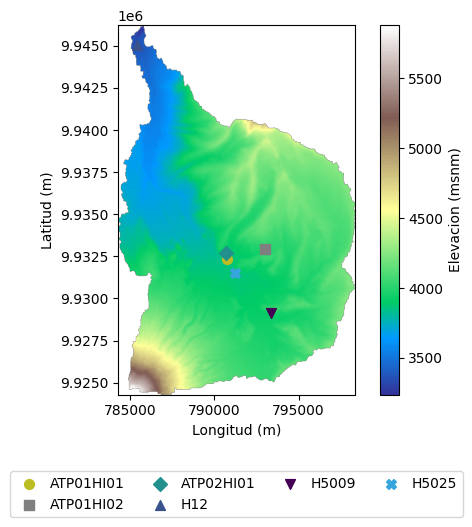

In [ ]:
# Rutas a las estaciones
dem_path = '/content/drive/MyDrive/Curso h028/PF_h028/DEM_PITA.tif'
stations_path = '/content/drive/MyDrive/Curso h028/PF_h028/ESTACIONES.shp'
map_var('tem_agu',dem_path,stations_path)

Verificacion de informacion completa

In [ ]:
detalle_fr('tem_agu')


Detalle de frecuencia de registro de estacion ATP01HI01:
fecha
300.0    719711
Name: count, dtype: int64
Total de registros: 719712
La serie de tiempo de la estacion ATP01HI01 debe tener 719712 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion ATP01HI02:
fecha
300.0    226079
Name: count, dtype: int64
Total de registros: 226080
La serie de tiempo de la estacion ATP01HI02 debe tener 226080 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion ATP02HI01:
fecha
300.0    719711
Name: count, dtype: int64
Total de registros: 719712
La serie de tiempo de la estacion ATP02HI01 debe tener 719712 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion H12:
fecha
300.0         187935
600.0          39614
13128600.0         1
Name: count, dtype: int64
Total de registros: 227551
La serie de tiempo de la estacion H12 debe tener 227551 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion H5009:
fecha
300.0    212831
Name: count, dtype: int64
Total de registros: 212832
La serie de tiempo de la estacion H5009 debe tener 212832 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion H5025:
fecha
300.0    755711
Name: count, dtype: int64
Total de registros: 755712
La serie de tiempo de la estacion H5025 debe tener 755712 registros.
✅ La serie se encuentra completa




Identificacion de registros duplicados

In [ ]:
rev_duplicados_mod("tem_agu")

Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Calculo del Porcentaje de informacion Faltante

In [ ]:
rev_nan("tem_agu")

,P_nan (%)
tem_agu,
ATP01HI01,5.004780
ATP01HI02,0.163659
ATP02HI01,0.121437
H12,0.025928
H5009,0.025842
H5025,1.398284


Calculo de porcentaje de informacion faltante

In [ ]:
# calcular el Porcentaje de valores nan de una serie de tiempo
cod_var = 'tem_agu'
rev_nan(cod_var)

,P_nan (%)
tem_agu,
ATP01HI01,5.004780
ATP01HI02,0.163659
ATP02HI01,0.121437
H12,0.025928
H5009,0.025842
H5025,1.398284


Grafica de registros historicos de Temperatura del agua

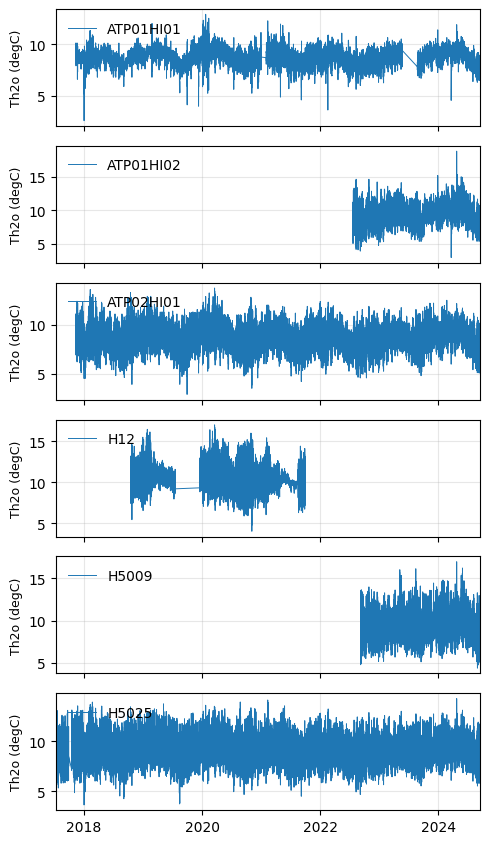

In [ ]:
Plot_df(Temh2o_PARAMH2O, "tem_agu")

### Creo dataset de Nivel de agua de las estaciones Hidrometricas

In [ ]:
variable = 'niv_agu'
Hh2o_PARAMH2O = df_var(variable)
Hh2o_PARAMH2O.head()

,ATP01HI01,ATP01HI02,ATP02HI01,H12,H48,H5009,H5025
fecha,,,,,,,
2005-01-01 00:00:00,NaN,NaN,NaN,19.11,NaN,NaN,NaN
2005-01-01 00:45:00,NaN,NaN,NaN,19.18,NaN,NaN,NaN
2005-01-01 01:05:00,NaN,NaN,NaN,20.54,NaN,NaN,NaN
2005-01-01 09:35:00,NaN,NaN,NaN,21.46,NaN,NaN,NaN
2005-01-01 11:35:00,NaN,NaN,NaN,22.39,NaN,NaN,NaN


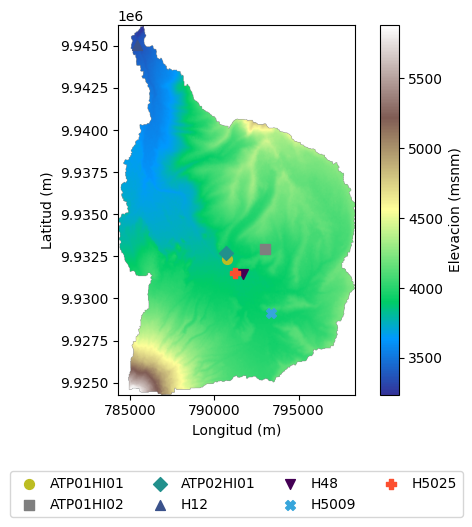

In [ ]:
# Mapa de estaciones
map_var('niv_agu',dem_path,stations_path)

In [ ]:
# Verificacion de informacion completa
detalle_fr('niv_agu')


Detalle de frecuencia de registro de estacion ATP01HI01:
fecha
300.0    719711
Name: count, dtype: int64
Total de registros: 719712
La serie de tiempo de la estacion ATP01HI01 debe tener 719712 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion ATP01HI02:
fecha
300.0    226079
Name: count, dtype: int64
Total de registros: 226080
La serie de tiempo de la estacion ATP01HI02 debe tener 226080 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion ATP02HI01:
fecha
300.0    719711
Name: count, dtype: int64
Total de registros: 719712
La serie de tiempo de la estacion ATP02HI01 debe tener 719712 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion H12:
fecha
600.0        550941
300.0        490952
900.0         37802
1200.0          578
1800.0          277
              ...  
1053600.0         1
3466800.0         1
3115200.0         1
4227600.0         1
2763000.0         1
Name: count, Length: 213, dtype: int64
Total de registros: 1081453
La serie de tiempo de la estacion H12 debe tener 1081453 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion H48:
fecha
600.0    178703
Name: count, dtype: int64
Total de registros: 178704
La serie de tiempo de la estacion H48 debe tener 178704 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion H5009:
fecha
300.0    212831
Name: count, dtype: int64
Total de registros: 212832
La serie de tiempo de la estacion H5009 debe tener 212832 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion H5025:
fecha
300.0    755711
Name: count, dtype: int64
Total de registros: 755712
La serie de tiempo de la estacion H5025 debe tener 755712 registros.
✅ La serie se encuentra completa




In [ ]:
# Identificacion de registros duplicados
rev_duplicados_mod("niv_agu")

Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



In [ ]:
rev_nan("niv_agu")

🚨 Estación H48 tiene más del 30% de Información faltante.


,P_nan (%)
niv_agu,
ATP01HI01,3.798603
ATP01HI02,3.932679
ATP02HI01,0.040711
H12,0.041241
H48,33.230929
H5009,9.954800
H5025,3.739123


In [ ]:
# Dado que una estacion no cumple con PIF, se procede a eliminarla
Hh2o_PARAMH2O.drop(columns=['H48'], inplace=True)

,ATP01HI01,ATP01HI02,ATP02HI01,H12,H5009,H5025
fecha,,,,,,
2005-01-01 00:00:00,NaN,NaN,NaN,19.11,NaN,NaN
2005-01-01 00:45:00,NaN,NaN,NaN,19.18,NaN,NaN
2005-01-01 01:05:00,NaN,NaN,NaN,20.54,NaN,NaN
2005-01-01 09:35:00,NaN,NaN,NaN,21.46,NaN,NaN
2005-01-01 11:35:00,NaN,NaN,NaN,22.39,NaN,NaN
...,...,...,...,...,...,...
2024-09-15 23:35:00,NaN,NaN,NaN,NaN,0.361,0.282
2024-09-15 23:40:00,NaN,NaN,NaN,NaN,0.361,0.281
2024-09-15 23:45:00,NaN,NaN,NaN,NaN,0.360,0.282


Grafica de registros historicos de Nivel de agua en estaciones hidrometricas

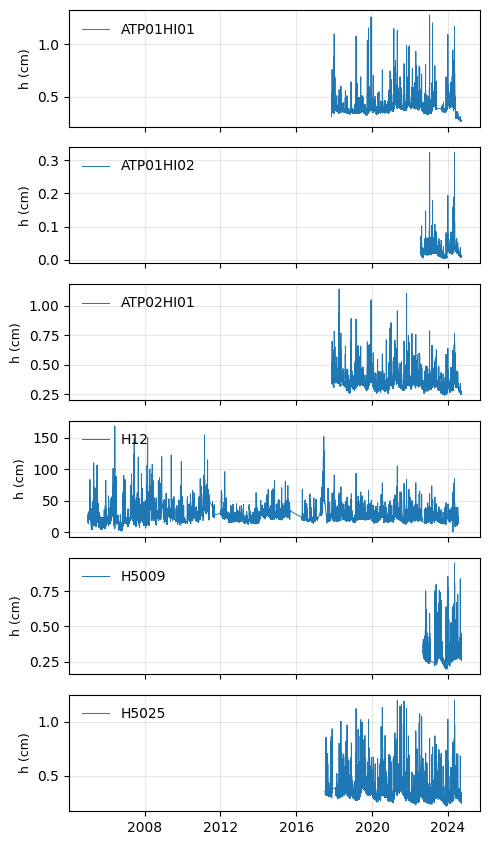

In [ ]:
# Llamar a la función para generar la gráfica
Plot_df(Hh2o_PARAMH2O, "niv_agu")

### Creo dataset de Caudal

In [ ]:
variable = 'cau'
Q_PARAMH2O = df_var(variable)
Q_PARAMH2O.head()

,ATP01HI01,ATP01HI02,ATP02HI01,H12,H48,H5009,H5025
fecha,,,,,,,
2005-01-01 00:00:00,NaN,NaN,NaN,1.642833,NaN,NaN,NaN
2005-01-01 00:45:00,NaN,NaN,NaN,1.650607,NaN,NaN,NaN
2005-01-01 01:05:00,NaN,NaN,NaN,1.803277,NaN,NaN,NaN
2005-01-01 09:35:00,NaN,NaN,NaN,1.908248,NaN,NaN,NaN
2005-01-01 11:35:00,NaN,NaN,NaN,2.015702,NaN,NaN,NaN


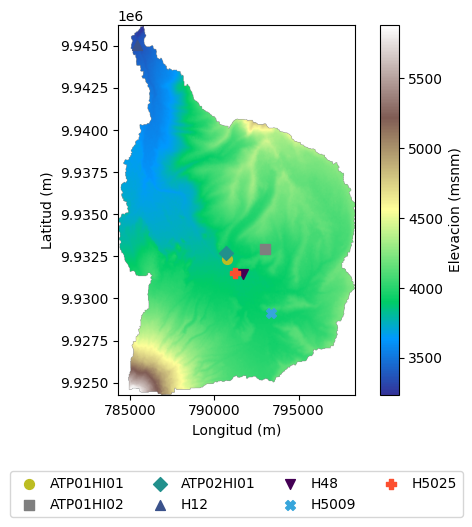

In [ ]:
# Mapa de estaciones
map_var('cau',dem_path,stations_path)

In [ ]:
# Verificacion de informacion completa
detalle_fr('cau')


Detalle de frecuencia de registro de estacion ATP01HI01:
fecha
300.0    719711
Name: count, dtype: int64
Total de registros: 719712
La serie de tiempo de la estacion ATP01HI01 debe tener 719712 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion ATP01HI02:
fecha
300.0    226079
Name: count, dtype: int64
Total de registros: 226080
La serie de tiempo de la estacion ATP01HI02 debe tener 226080 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion ATP02HI01:
fecha
300.0    714239
Name: count, dtype: int64
Total de registros: 714240
La serie de tiempo de la estacion ATP02HI01 debe tener 714240 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion H12:
fecha
300.0         741661
600.0         437257
900.0          37802
1200.0           578
1800.0           276
               ...  
20044200.0         1
4412400.0          1
1053600.0          1
3466800.0          1
3115200.0          1
Name: count, Length: 211, dtype: int64
Total de registros: 1218471
La serie de tiempo de la estacion H12 debe tener 1218471 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion H48:
fecha
600.0    178703
Name: count, dtype: int64
Total de registros: 178704
La serie de tiempo de la estacion H48 debe tener 178704 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion H5009:
fecha
300.0    225215
Name: count, dtype: int64
Total de registros: 225216
La serie de tiempo de la estacion H5009 debe tener 225216 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion H5025:
fecha
300.0    721439
Name: count, dtype: int64
Total de registros: 721440
La serie de tiempo de la estacion H5025 debe tener 721440 registros.
✅ La serie se encuentra completa




In [ ]:
# Identificacion de registros duplicados
rev_duplicados_mod("cau")

Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



In [ ]:
rev_nan("cau")

🚨 Estación H48 tiene más del 30% de Información faltante.


,P_nan (%)
cau,
ATP01HI01,4.533063
ATP01HI02,3.977353
ATP02HI01,0.014001
H12,10.335002
H48,33.230929
H5009,9.407413
H5025,2.531188


In [ ]:
# Elimino la columna H48
Q_PARAMH2O.drop(columns=['H48'], inplace=True)

Grafica de registros historicos de Caudal

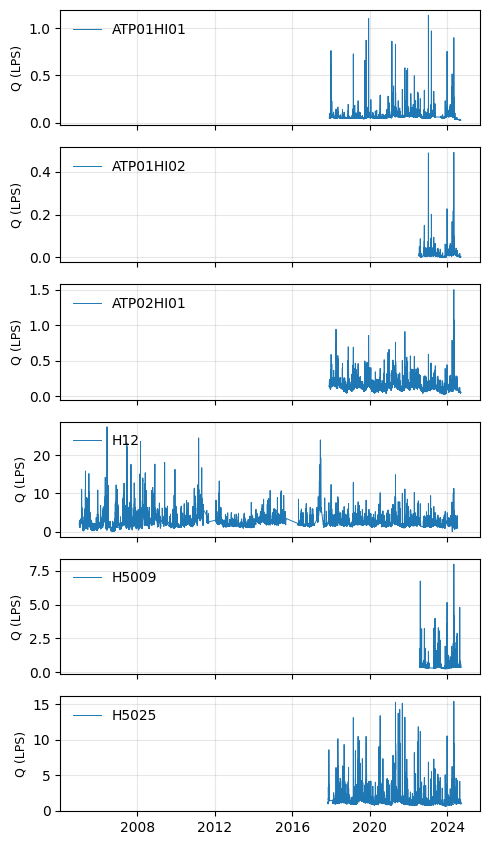

In [ ]:
# Llamar a la función para generar la gráfica
Plot_df(Q_PARAMH2O, "cau")

### Creo dataset de Temperatura ambiente

In [ ]:
variable = 'tem_amb'
TemA_PARAMH2O = df_var(variable)
TemA_PARAMH2O.head()

,ATP01PT01,ATP01PT02,ATP02PT01,C11,M5076,M5124
fecha,,,,,,
2011-07-05 00:00:00,NaN,NaN,NaN,11.55,NaN,NaN
2011-07-05 00:05:00,NaN,NaN,NaN,11.55,NaN,NaN
2011-07-05 00:10:00,NaN,NaN,NaN,11.29,NaN,NaN
2011-07-05 00:15:00,NaN,NaN,NaN,11.10,NaN,NaN
2011-07-05 00:20:00,NaN,NaN,NaN,11.13,NaN,NaN


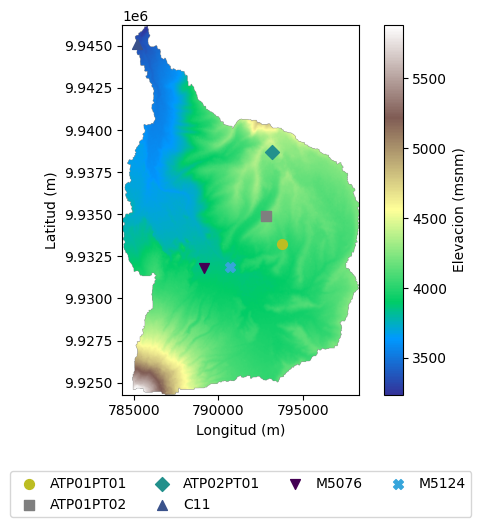

In [ ]:
# Mapa de estaciones
map_var('tem_amb',dem_path,stations_path)

In [ ]:
# Verificacion de informacion completa
detalle_fr('tem_amb')


Detalle de frecuencia de registro de estacion ATP01PT01:
fecha
300.0    316223
Name: count, dtype: int64
Total de registros: 316224
La serie de tiempo de la estacion ATP01PT01 debe tener 316224 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion ATP01PT02:
fecha
300.0    316511
Name: count, dtype: int64
Total de registros: 316512
La serie de tiempo de la estacion ATP01PT02 debe tener 316512 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion ATP02PT01:
fecha
300.0    343871
Name: count, dtype: int64
Total de registros: 343872
La serie de tiempo de la estacion ATP02PT01 debe tener 343872 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion C11:
fecha
6.0        785426
294.0      785425
300.0      528649
20700.0         1
Name: count, dtype: int64
Total de registros: 2099502
La serie de tiempo de la estacion C11 debe tener 2099502 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion M5076:
fecha
300.0     704819
600.0     233856
1200.0         2
1800.0         1
1500.0         1
2100.0         1
900.0          1
Name: count, dtype: int64
Total de registros: 938682
La serie de tiempo de la estacion M5076 debe tener 938682 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion M5124:
fecha
300.0    217151
Name: count, dtype: int64
Total de registros: 217152
La serie de tiempo de la estacion M5124 debe tener 217152 registros.
✅ La serie se encuentra completa




In [ ]:
# Identificacion de registros duplicados
rev_duplicados_mod("tem_amb")

Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



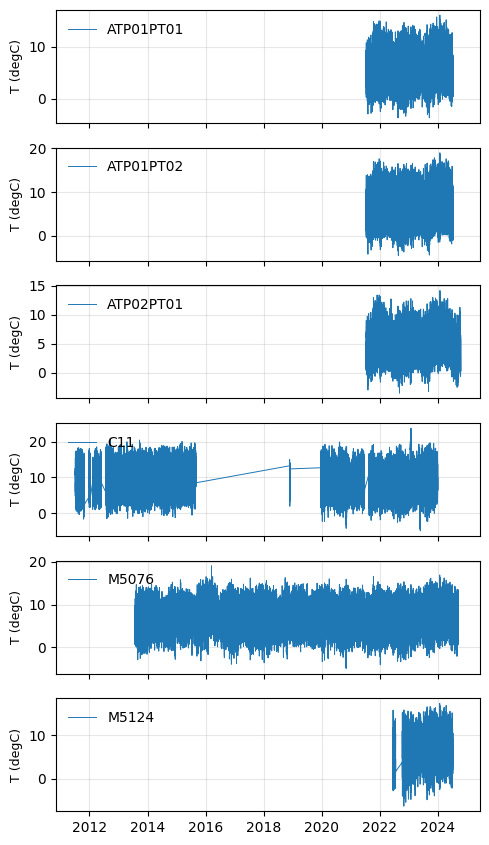

In [ ]:
# Grafica de registros historicos de Temperatura ambiente
Plot_var('tem_amb')

### Creo dataset de Precipitacion

In [ ]:
variable = 'precip'
P_PARAMH2O = df_var(variable)
P_PARAMH2O.head()

,ATP01PT01,ATP01PT02,ATP02PT01,C11,M5076,M5124,P39
fecha,,,,,,,
2003-11-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-11-07 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-11-07 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-11-07 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-11-07 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


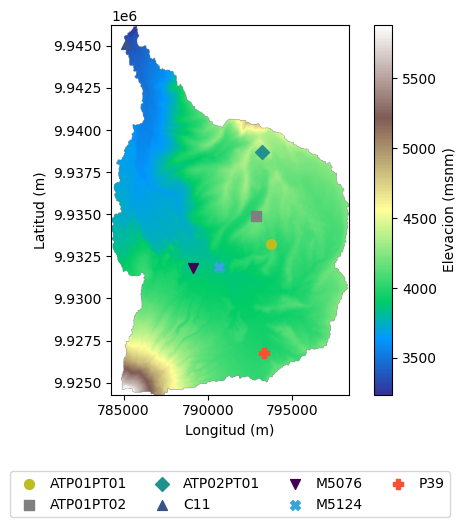

In [ ]:
# Mapa de estaciones
map_var('precip',dem_path,stations_path)

In [ ]:
# Verificacion de informacion completa
detalle_fr('precip')


Detalle de frecuencia de registro de estacion ATP01PT01:
fecha
300.0    719711
Name: count, dtype: int64
Total de registros: 719712
La serie de tiempo de la estacion ATP01PT01 debe tener 719712 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion ATP01PT02:
fecha
300.0    719999
Name: count, dtype: int64
Total de registros: 720000
La serie de tiempo de la estacion ATP01PT02 debe tener 720000 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion ATP02PT01:
fecha
300.0    729503
Name: count, dtype: int64
Total de registros: 729504
La serie de tiempo de la estacion ATP02PT01 debe tener 729504 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion C11:
fecha
300.0        1384101
60.0            8279
2505900.0          1
3859560.0          1
Name: count, dtype: int64
Total de registros: 1392383
La serie de tiempo de la estacion C11 debe tener 1392383 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion M5076:
fecha
300.0    1336895
Name: count, dtype: int64
Total de registros: 1336896
La serie de tiempo de la estacion M5076 debe tener 1336896 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion M5124:
fecha
300.0    225791
Name: count, dtype: int64
Total de registros: 225792
La serie de tiempo de la estacion M5124 debe tener 225792 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion P39:
fecha
300.0    2119679
Name: count, dtype: int64
Total de registros: 2119680
La serie de tiempo de la estacion P39 debe tener 2119680 registros.
✅ La serie se encuentra completa




In [ ]:
# Identificacion de registros duplicados
rev_duplicados_mod("precip")

Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



In [ ]:
rev_nan("precip")

,P_nan (%)
precip,
ATP01PT01,0.057662
ATP01PT02,2.542639
ATP02PT01,0.559284
C11,10.670843
M5076,2.625709
M5124,0.143495
P39,14.334758


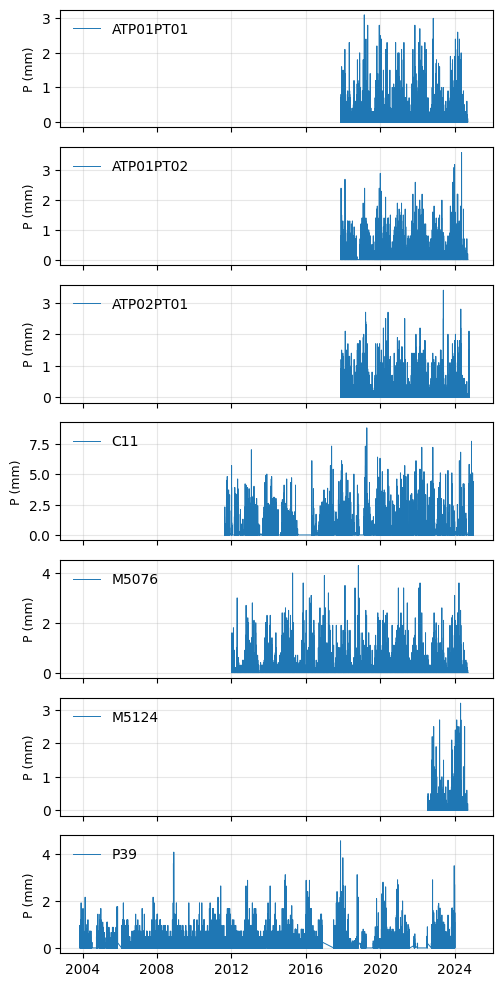

In [ ]:
# Grafica de registros historicos de Precipitacion
Plot_var("precip")

### Creo dataset de Humedad Relativa

In [ ]:
variable = 'hum_rel'
Hr_PARAMH2O = df_var(variable)
Hr_PARAMH2O.head()

,ATP01PT01,ATP01PT02,ATP02PT01,C11,M5124
fecha,,,,,
2011-07-05 00:00:00,NaN,NaN,NaN,73.337,NaN
2011-07-05 00:05:00,NaN,NaN,NaN,73.542,NaN
2011-07-05 00:10:00,NaN,NaN,NaN,74.092,NaN
2011-07-05 00:15:00,NaN,NaN,NaN,74.891,NaN
2011-07-05 00:20:00,NaN,NaN,NaN,77.727,NaN


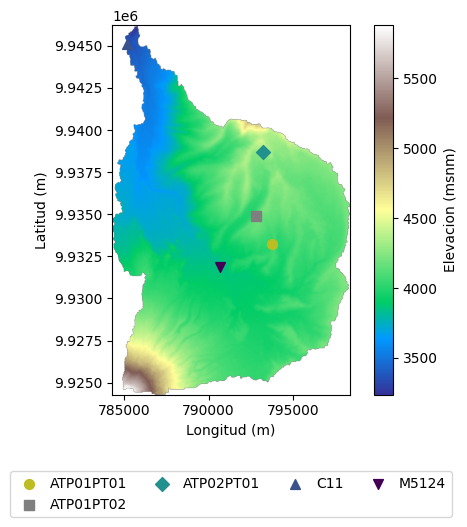

In [ ]:
# Mapa de estaciones
map_var('hum_rel',dem_path,stations_path)

In [ ]:
# Verificacion de informacion completa
detalle_fr('hum_rel')


Detalle de frecuencia de registro de estacion ATP01PT01:
fecha
300.0    316223
Name: count, dtype: int64
Total de registros: 316224
La serie de tiempo de la estacion ATP01PT01 debe tener 316224 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion ATP01PT02:
fecha
300.0    316511
Name: count, dtype: int64
Total de registros: 316512
La serie de tiempo de la estacion ATP01PT02 debe tener 316512 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion ATP02PT01:
fecha
300.0    343871
Name: count, dtype: int64
Total de registros: 343872
La serie de tiempo de la estacion ATP02PT01 debe tener 343872 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion C11:
fecha
6.0        781970
294.0      781969
300.0      532104
21000.0         1
Name: count, dtype: int64
Total de registros: 2096045
La serie de tiempo de la estacion C11 debe tener 2096045 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion M5124:
fecha
300.0    217151
Name: count, dtype: int64
Total de registros: 217152
La serie de tiempo de la estacion M5124 debe tener 217152 registros.
✅ La serie se encuentra completa




In [ ]:
# Identificacion de registros duplicados
rev_duplicados_mod("hum_rel")

Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



In [ ]:
rev_nan("hum_rel")

🚨 Estación C11 tiene más del 30% de Información faltante.


,P_nan (%)
hum_rel,
ATP01PT01,1.226662
ATP01PT02,0.147546
ATP02PT01,0.480411
C11,62.712633
M5124,0.402023


In [ ]:
# Elimino la columna C11
Hr_PARAMH2O.drop(columns=['C11'], inplace=True)

Grafica de registros historicos de Humedad relativa

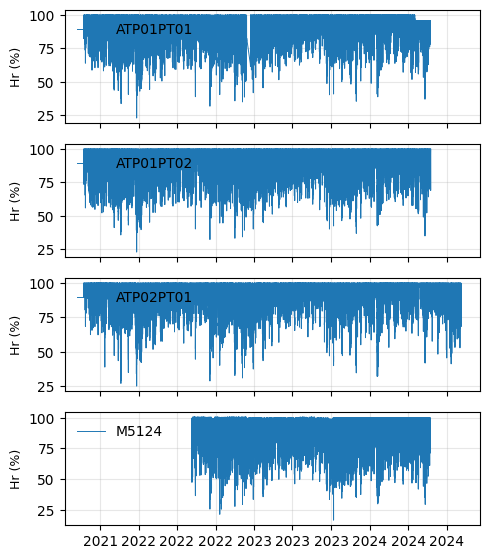

In [ ]:
# Llamar a la función para generar la gráfica
Plot_df(Hr_PARAMH2O, "hum_rel")

### Creo dataset de Velocidad del viento

In [ ]:
variable = 'vel_vie'
Vv_PARAMH2O = df_var(variable)
Vv_PARAMH2O.head()

,C11,M5124
fecha,,
2011-07-05 00:00:00,0.109,NaN
2011-07-05 00:05:00,0.469,NaN
2011-07-05 00:10:00,1.625,NaN
2011-07-05 00:15:00,0.477,NaN
2011-07-05 00:20:00,0.406,NaN


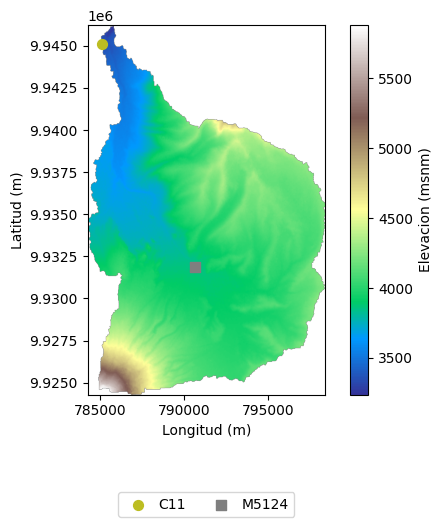

In [ ]:
# Mapa de estaciones
map_var('vel_vie',dem_path,stations_path)

In [ ]:
# Verificacion de informacion completa
detalle_fr('vel_vie')


Detalle de frecuencia de registro de estacion C11:
fecha
6.0        779045
294.0      779044
300.0      534697
600.0          69
900.0          24
1500.0          8
1200.0          8
2100.0          7
21300.0         1
Name: count, dtype: int64
Total de registros: 2092904
La serie de tiempo de la estacion C11 debe tener 2092904 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion M5124:
fecha
300.0    265247
Name: count, dtype: int64
Total de registros: 265248
La serie de tiempo de la estacion M5124 debe tener 265248 registros.
✅ La serie se encuentra completa




In [ ]:
# Identificacion de registros duplicados
rev_duplicados_mod("vel_vie")

Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



In [ ]:
rev_nan("vel_vie")

🚨 Estación C11 tiene más del 30% de Información faltante.


,P_nan (%)
vel_vie,
C11,63.973933
M5124,9.569535


In [ ]:
# Elimino la columna C11
Vv_PARAMH2O.drop(columns=['C11'], inplace=True)

KeyError: "['C11'] not found in axis"

Grafica de registros historicos de Velocidad del viento

In [ ]:
Vv_PARAMH2O.head()

,M5124
fecha,
2011-07-05 00:00:00,NaN
2011-07-05 00:05:00,NaN
2011-07-05 00:10:00,NaN
2011-07-05 00:15:00,NaN
2011-07-05 00:20:00,NaN


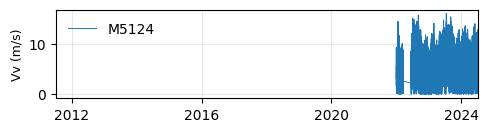

In [ ]:
# Llamar a la función para generar la gráfica
Plot_df(Vv_PARAMH2O, "vel_vie")

### Creo dataset de Radiacion solar

In [ ]:
variable = 'rad_sol'
Rs_PARAMH2O = df_var(variable)
Rs_PARAMH2O.head()

,C11,M5124
fecha,,
2011-07-05 00:00:00,0.000,NaN
2011-07-05 00:05:00,1.974,NaN
2011-07-05 00:10:00,1.615,NaN
2011-07-05 00:15:00,1.256,NaN
2011-07-05 00:20:00,0.538,NaN


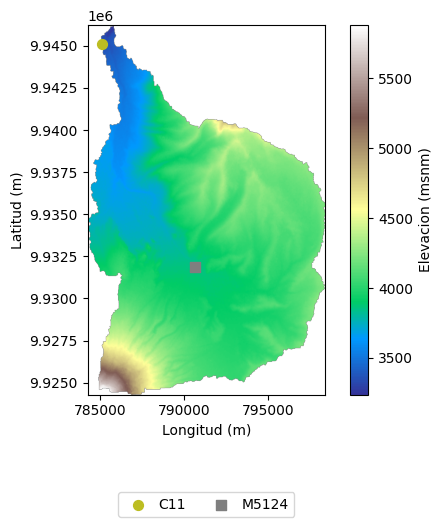

In [ ]:
# Mapa de estaciones
map_var('rad_sol',dem_path,stations_path)

In [ ]:
# Verificacion de informacion completa
detalle_fr('rad_sol')


Detalle de frecuencia de registro de estacion C11:
fecha
6.0        785426
294.0      785425
300.0      528649
20700.0         1
Name: count, dtype: int64
Total de registros: 2099502
La serie de tiempo de la estacion C11 debe tener 2099502 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion M5124:
fecha
300.0    217151
Name: count, dtype: int64
Total de registros: 217152
La serie de tiempo de la estacion M5124 debe tener 217152 registros.
✅ La serie se encuentra completa




In [ ]:
# Identificacion de registros duplicados
rev_duplicados_mod("rad_sol")

Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



In [ ]:
rev_nan("rad_sol")

🚨 Estación C11 tiene más del 30% de Información faltante.


,P_nan (%)
rad_sol,
C11,61.468005
M5124,15.583554


In [ ]:
# Elimino la columna C11
Rs_PARAMH2O.drop(columns=['C11'], inplace=True)

Grafica de registros historicos de Radiacion Solar

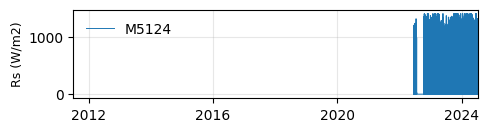

In [ ]:
# Llamar a la función para generar la gráfica
Plot_df(Rs_PARAMH2O, "rad_sol")

### Creo dataset de Presion atmosferica

In [ ]:
variable = 'pre_atm'
Patm_PARAMH2O = df_var(variable)
Patm_PARAMH2O.head()

,C11,M5124
fecha,,
2011-07-05 00:00:00,NaN,NaN
2011-07-05 00:05:00,NaN,NaN
2011-07-05 00:10:00,NaN,NaN
2011-07-05 00:15:00,NaN,NaN
2011-07-05 00:20:00,NaN,NaN


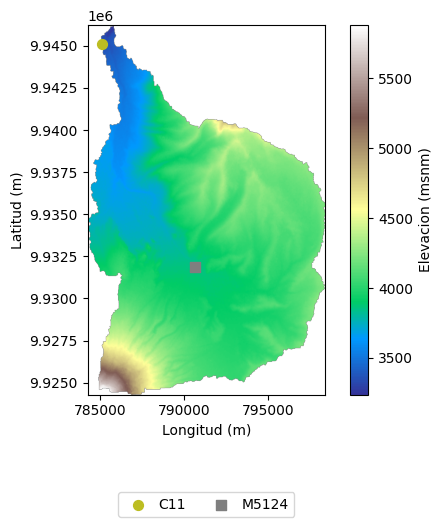

In [ ]:
# Mapa de estaciones
map_var('pre_atm',dem_path,stations_path)

In [ ]:
# Verificacion de informacion completa
detalle_fr('pre_atm')


Detalle de frecuencia de registro de estacion C11:
fecha
6.0        785426
294.0      785425
300.0      528649
20700.0         1
Name: count, dtype: int64
Total de registros: 2099502
La serie de tiempo de la estacion C11 debe tener 2099502 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion M5124:
fecha
300.0    235295
Name: count, dtype: int64
Total de registros: 235296
La serie de tiempo de la estacion M5124 debe tener 235296 registros.
✅ La serie se encuentra completa




In [ ]:
# Identificacion de registros duplicados
rev_duplicados_mod("pre_atm")

Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



In [ ]:
rev_nan("pre_atm")

🚨 Estación C11 tiene más del 30% de Información faltante.


,P_nan (%)
pre_atm,
C11,62.253144
M5124,0.138124


In [ ]:
# Elimino la columna C11
Patm_PARAMH2O.drop(columns=['C11'], inplace=True)

Grafica de registros historicos de Presion atmosferica

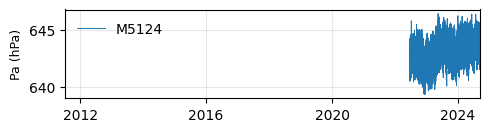

In [ ]:
# Llamar a la función para generar la gráfica
Plot_df(Patm_PARAMH2O, "pre_atm")

### Creo dataset de Direccion del viento

In [ ]:
variable = 'dir_vie'
Dv_PARAMH2O = df_var(variable)
Dv_PARAMH2O.head()

,C11,M5124
fecha,,
2011-07-05 00:00:00,0.109,NaN
2011-07-05 00:05:00,0.469,NaN
2011-07-05 00:10:00,1.625,NaN
2011-07-05 00:15:00,0.477,NaN
2011-07-05 00:20:00,0.406,NaN


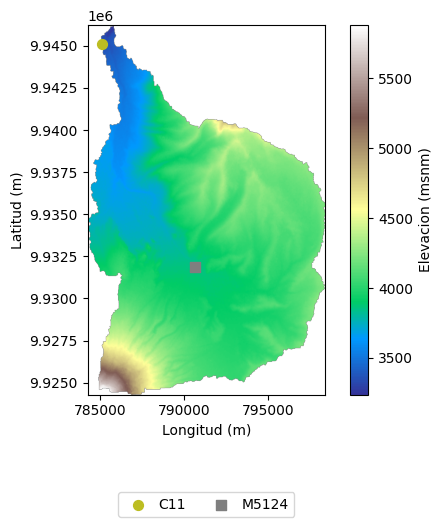

In [ ]:
# Mapa de estaciones
map_var('dir_vie',dem_path,stations_path)

In [ ]:
# Verificacion de informacion completa
detalle_fr('dir_vie')


Detalle de frecuencia de registro de estacion C11:
fecha
6.0        779045
294.0      779044
300.0      534697
600.0          69
900.0          24
1500.0          8
1200.0          8
2100.0          7
21300.0         1
Name: count, dtype: int64
Total de registros: 2092904
La serie de tiempo de la estacion C11 debe tener 2092904 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion M5124:
fecha
300.0    265247
Name: count, dtype: int64
Total de registros: 265248
La serie de tiempo de la estacion M5124 debe tener 265248 registros.
✅ La serie se encuentra completa




In [ ]:
# Identificacion de registros duplicados
rev_duplicados_mod("dir_vie")

Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



In [ ]:
rev_nan("dir_vie")

🚨 Estación C11 tiene más del 30% de Información faltante.


,P_nan (%)
dir_vie,
C11,63.973933
M5124,9.569535


In [ ]:
# Elimino la columna C11
Dv_PARAMH2O.drop(columns=['C11'], inplace=True)

Grafica de registros historicos de Direccion del viento

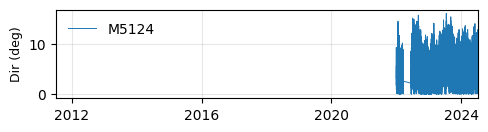

In [ ]:
# Llamar a la función para generar la gráfica
Plot_df(Dv_PARAMH2O, "dir_vie")

### Creo dataset de Caudal aforado con veredero

In [ ]:
variable = 'cau_afo'
Qafo_PARAMH2O = df_var(variable)
Qafo_PARAMH2O.head()

,PT01,PT02,PT03,PT04,PT05,PT06,PT08,PT10,PT15,PT16,TT21
fecha,,,,,,,,,,,
1979-02-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-02-07 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-02-07 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-02-07 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-02-07 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


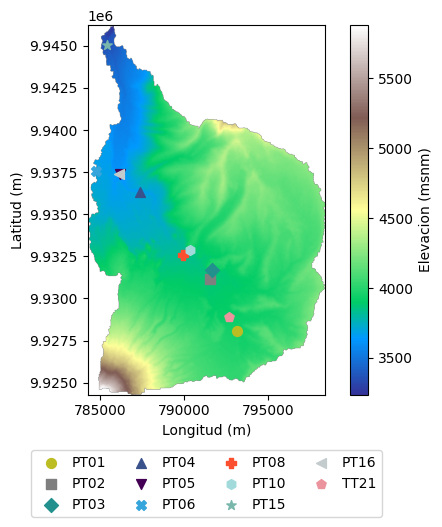

In [ ]:
# Mapa de estaciones
dem_path = '/content/drive/MyDrive/Curso h028/PF_h028/DEM_PITA.tif'
stations_path = '/content/drive/MyDrive/Curso h028/PF_h028/ESTACIONES.shp'
map_var('cau_afo',dem_path,stations_path)

In [ ]:
# Verificacion de informacion completa
detalle_fr('cau_afo')


Detalle de frecuencia de registro de estacion PT01:
fecha
300.0    1138751
Name: count, dtype: int64
Total de registros: 1138752
La serie de tiempo de la estacion PT01 debe tener 1138752 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion PT02:
fecha
300.0    1746719
Name: count, dtype: int64
Total de registros: 1746720
La serie de tiempo de la estacion PT02 debe tener 1746720 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion PT03:
fecha
300.0    1563839
Name: count, dtype: int64
Total de registros: 1563840
La serie de tiempo de la estacion PT03 debe tener 1563840 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion PT04:
fecha
300.0    1563839
Name: count, dtype: int64
Total de registros: 1563840
La serie de tiempo de la estacion PT04 debe tener 1563840 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion PT05:
fecha
300.0    4090751
Name: count, dtype: int64
Total de registros: 4090752
La serie de tiempo de la estacion PT05 debe tener 4090752 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion PT06:
fecha
300.0    4089311
Name: count, dtype: int64
Total de registros: 4089312
La serie de tiempo de la estacion PT06 debe tener 4089312 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion PT08:
fecha
300.0    3865247
Name: count, dtype: int64
Total de registros: 3865248
La serie de tiempo de la estacion PT08 debe tener 3865248 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion PT10:
fecha
300.0    3857183
Name: count, dtype: int64
Total de registros: 3857184
La serie de tiempo de la estacion PT10 debe tener 3857184 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion PT15:
fecha
300.0    4417919
Name: count, dtype: int64
Total de registros: 4417920
La serie de tiempo de la estacion PT15 debe tener 4417920 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion PT16:
fecha
300.0    1834271
Name: count, dtype: int64
Total de registros: 1834272
La serie de tiempo de la estacion PT16 debe tener 1834272 registros.
✅ La serie se encuentra completa





Detalle de frecuencia de registro de estacion TT21:
fecha
300.0    1738079
Name: count, dtype: int64
Total de registros: 1738080
La serie de tiempo de la estacion TT21 debe tener 1738080 registros.
✅ La serie se encuentra completa




In [ ]:
# Identificacion de registros duplicados
rev_duplicados_mod("cau_afo")

Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



Número de fechas duplicadas: 0
✅ No se encontraron fechas duplicadas.



In [ ]:
rev_nan("cau_afo")

🚨 Estación PT01 tiene más del 30% de Información faltante.
🚨 Estación PT02 tiene más del 30% de Información faltante.
🚨 Estación PT03 tiene más del 30% de Información faltante.
🚨 Estación PT04 tiene más del 30% de Información faltante.
🚨 Estación PT05 tiene más del 30% de Información faltante.
🚨 Estación PT06 tiene más del 30% de Información faltante.
🚨 Estación PT08 tiene más del 30% de Información faltante.
🚨 Estación PT10 tiene más del 30% de Información faltante.
🚨 Estación PT15 tiene más del 30% de Información faltante.
🚨 Estación PT16 tiene más del 30% de Información faltante.
🚨 Estación TT21 tiene más del 30% de Información faltante.


,P_nan (%)
cau_afo,
PT01,99.996663
PT02,99.991355
PT03,99.989449
PT04,99.992007
PT05,99.988951
PT06,99.987969
PT08,99.993791
PT10,99.995722
PT15,99.983431


Grafica de registros historicos de Caudales aforados con vertedero

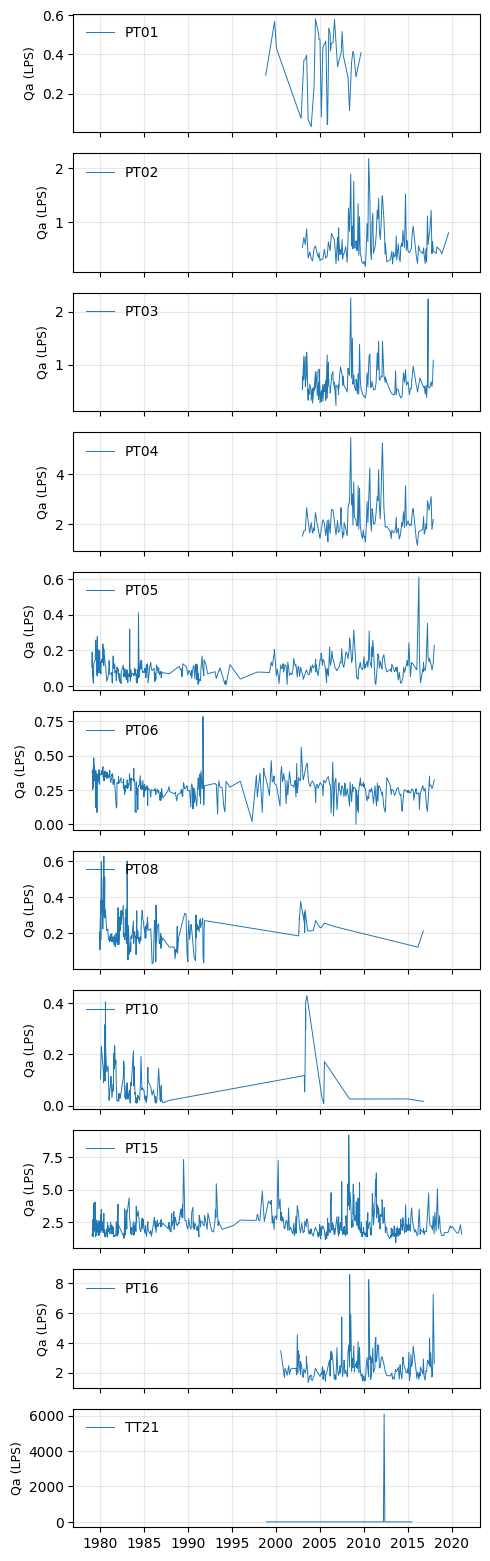

In [ ]:
# Llamar a la función para generar la gráfica
Plot_var("cau_afo")

# Calidad inicial